# Vision Transformers for image segmentation

In [1]:
import math
import random

import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

from torchvision.transforms import Compose, RandomCrop, ToTensor, Normalize
from torchvision.datasets import OxfordIIITPet

RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
TORCH_GEN = torch.manual_seed(RANDOM_SEED)

## 1. Fetch data, set some hyperparameters and preprocess

In [2]:
NUM_CLASSES = 4
PAD, BACKGROUND, PET, OUTLINE = 0, 1, 2, 3

PATCH_H, PATCH_W = 16, 16
PATCH_SIZE = PATCH_H * PATCH_W
NUM_PATCHES_H, NUM_PATCHES_W = 16, 16
NUM_PATCHES = NUM_PATCHES_H * NUM_PATCHES_W

INPUT_SIZE = 3 * PATCH_SIZE  # 3 channels for RGB
OUTPUT_SIZE = NUM_CLASSES * PATCH_SIZE  # 4 classes for segmentation: background, pet, outline, padding (ignored in the loss function)


MEAN = [0.485, 0.456, 0.406]  # ImageNet normalization
STD = [0.229, 0.224, 0.225]

data_transforms = Compose([
    ToTensor(),
    Normalize(MEAN, STD),
])

class LabelTransform:
    # The segmentation targets of the Oxford-IIIT Pet Dataset have three unique values:  [0.0039, 0.0078, 0.0118]
    # These values correspond to the three classes: background, pet and outline.
    # There is one additional class, the padding, which is added when we crop the images
    def __call__(self, mask):
        labels = torch.zeros_like(mask, dtype=torch.long)  # PAD is 0
            
        labels[mask <= 0.0118 + 1e-3] = BACKGROUND
        labels[mask <= 0.0078 + 1e-3] = PET
        labels[mask <= 0.0039 + 1e-3] = OUTLINE
        
        return labels


target_transforms = Compose([
    ToTensor(),
    LabelTransform()
])

ds = OxfordIIITPet(root='data', download=True, split="trainval", target_types="segmentation", transform=data_transforms, target_transform=target_transforms)

In [3]:
class CropDataset(torch.utils.data.Dataset):
    def __init__(self, ds):
        self.ds = ds
        self.crop_size_h = PATCH_H * NUM_PATCHES_H
        self.crop_size_w = PATCH_W * NUM_PATCHES_W

    def __getitem__(self, idx):
        img, target = self.ds[idx]
        _, h, w = img.shape  # original dimensions

        # Pad images that are smaller than the crop size
        pad_h = max(0, self.crop_size_h - h)
        pad_w = max(0, self.crop_size_w - w)
        padding = (0, pad_w, 0, pad_h)  # left, right, top, bottom
        img = F.pad(img, padding, mode='constant', value=0)  # pad with zero valued pixels
        target = F.pad(target, padding, mode='constant', value=0)  # 0 is the padding class

        _, h, w = img.shape  # new dimensions after padding

        i = random.randint(0, h - self.crop_size_h)
        j = random.randint(0, w - self.crop_size_w)

        img = img[:, i:i+self.crop_size_h, j:j+self.crop_size_w]
        target = target[:, i:i+self.crop_size_h, j:j+self.crop_size_w]

        return img, target
    
    def __len__(self): return len(self.ds)  # same length as the original dataset
    
ds = CropDataset(ds)
train_ds, val_ds = random_split(ds, [0.8, 0.2], generator=TORCH_GEN)

In [4]:
train_ds[0][0].shape, train_ds[0][1].shape

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

## 2. Util functions

- function to visualize a grid of images, masks or both overlayed and a function to divide our images/masks
- function to divide our images / masks up into a sequence of patches

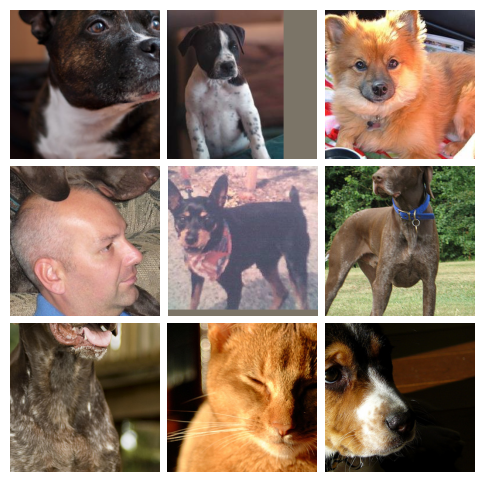

In [5]:
from matplotlib.colors import ListedColormap


def plot_imgs(imgs=None, masks=None, figsize=(12, 12), alpha=0.4):
    num_imgs = len(imgs or masks)
    nrows = int(math.ceil(math.sqrt(num_imgs)))
    ncols = int(math.ceil(num_imgs / nrows))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten() if num_imgs > 1 else [axes]
    
    # Define segmentation colormap
    seg_colors = ['black', 'orange', 'green', 'purple']
    seg_cmap = ListedColormap(seg_colors)
    
    for i, ax in enumerate(axes):
        if imgs is not None:
            img = imgs[i] * torch.tensor(STD).view(3, 1, 1) + torch.tensor(MEAN).view(3, 1, 1)  # unnormalize
            ax.imshow(img.permute(1, 2, 0).numpy())
        
        if masks is not None:
            mask = masks[i].squeeze().numpy()  # Remove channel dimension if present
            ax.imshow(mask, cmap=seg_cmap, alpha=alpha, vmin=0, vmax=3)
        
        ax.axis('off')
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()


imgs, masks = map(list, zip(*[train_ds[i] for i in random.sample(range(len(train_ds)), 9)]))
plot_imgs(imgs, figsize=(6, 6))


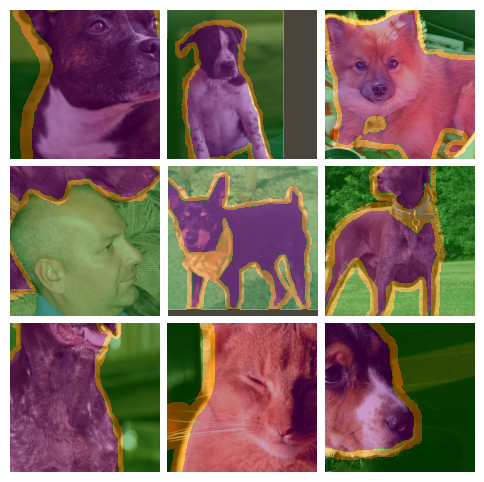

In [6]:
plot_imgs(imgs=imgs, masks=masks, figsize=(6, 6))

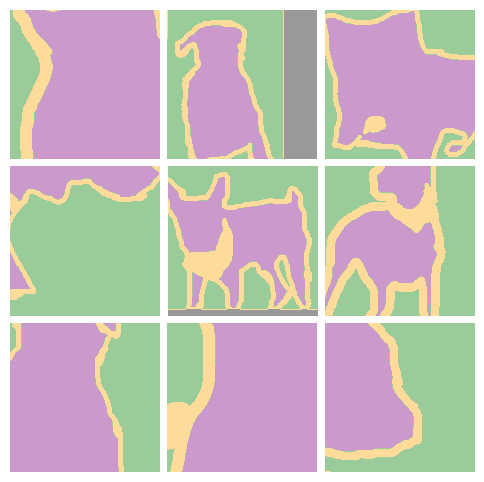

In [7]:
plot_imgs(masks=masks, figsize=(6, 6))

Before implementing a vision transformer, we need to represent images in a format the model can understand. This requires creating "patches" – dividing the image into many smaller, equal-sized chunks. By treating the image as a sequence of patches (read from left to right, like a book), the transformer can then imbibe the image data!

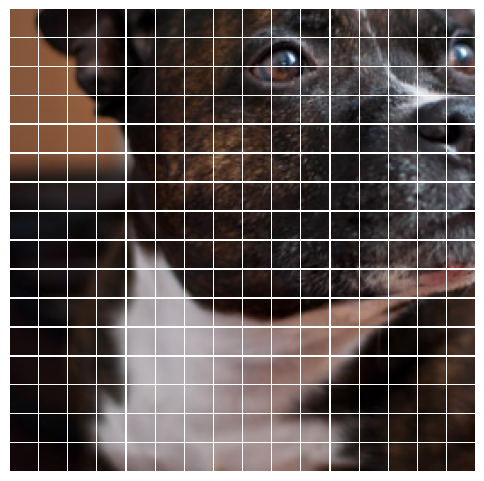

In [8]:
def patch(imgs):
    if (unbatched := imgs.ndim == 3):
        imgs = imgs.unsqueeze(0)  # add batch dimension if it's not there

    B, C, H, W = imgs.size()

    patches = imgs.unfold(2, PATCH_H, PATCH_W)  # unfold along height
    patches = patches.unfold(3, PATCH_H, PATCH_W)  # unfold along width
    patches = patches.contiguous().view(B, C, -1, PATCH_H, PATCH_W)  # gather the different unfolds into 
    patches = patches.permute(0, 2, 1, 3, 4).contiguous()  # ensure the dimensions are in the right order before flattening
    patches = patches.view(B, -1, C * PATCH_H * PATCH_W)  # flatten
    
    return patches.squeeze(0) if unbatched else patches

def unpatch(patches):
    if (unbatched := patches.ndim == 2):
        patches = patches.unsqueeze(0)  # add batch dimension if it's not there
        
    B, N, D = patches.size()
    C = D // (PATCH_H * PATCH_W)  # 1 for mask, 3 for image
    H, W = PATCH_H * NUM_PATCHES_H, PATCH_W * NUM_PATCHES_W

    # view and permute to get the original memory layout
    patches = patches.view(B, NUM_PATCHES_H, NUM_PATCHES_W, C, PATCH_H, PATCH_W)
    patches = patches.permute(0, 3, 1, 4, 2, 5).contiguous()
    
    imgs = patches.view(B, C, H, W)  # now the dimensions are in the right order to form the image again
    
    return imgs.squeeze(0) if unbatched else imgs
    
    
assert torch.allclose(unpatch(patch(imgs[0])), imgs[0]), "Patching and unpatching is not consistent for image"
assert torch.allclose(unpatch(patch(masks[0])), masks[0]), "Patching and unpatching is not consistent for mask"

patches = patch(imgs[0])
plot_imgs(imgs=list(patches.reshape(-1, 3, PATCH_H, PATCH_W)), figsize=(6, 6))

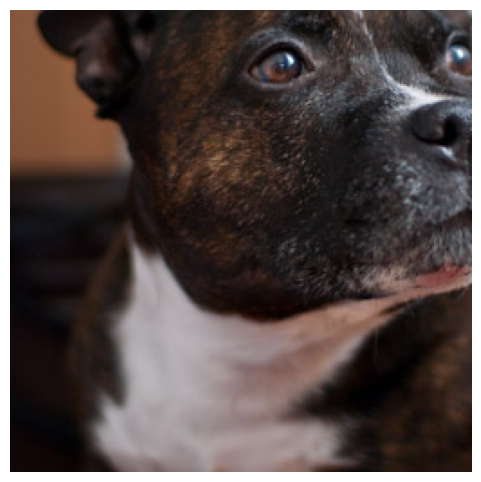

In [9]:
plot_imgs(imgs=[unpatch(patches)], figsize=(6, 6))

So this is effectively what the transformer will see (except each patch will be flattened (along with the RGB dimension))

## 3. Overfit

In [10]:
NUM_HEADS = 8
NUM_LAYERS = 8
EMBED_DIM = 512

class TransformerBlock(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.norm1 = nn.LayerNorm(EMBED_DIM)        
        self.attn = nn.MultiheadAttention(EMBED_DIM, NUM_HEADS)
        
        self.norm2 = nn.LayerNorm(EMBED_DIM)
        self.mlp = nn.Sequential(
            nn.Linear(EMBED_DIM, 4 * EMBED_DIM),
            nn.GELU(),
            nn.Linear(4 * EMBED_DIM, EMBED_DIM),
        )
        
    def forward(self, x):
        x = self.norm1(x)
        x = x + self.attn(x, x, x)[0]  # the MultiheadAttention module returns both the output and the attention scores
        return x + self.mlp(self.norm2(x))


class VisionTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.positional_embedding = nn.Embedding(NUM_PATCHES, EMBED_DIM)
        self.patch_embedding = nn.Linear(INPUT_SIZE, EMBED_DIM)
        
        self.transformer = nn.Sequential(*[TransformerBlock() for _ in range(NUM_LAYERS)])
        
        self.norm = nn.LayerNorm(EMBED_DIM)
        self.fc = nn.Linear(EMBED_DIM, OUTPUT_SIZE)
        
    def forward(self, x):
        device = x.device
        
        positions = torch.arange(NUM_PATCHES, device=device).unsqueeze(0)
        x = self.patch_embedding(x) + self.positional_embedding(positions)
        
        x = self.transformer(x)    
    
        return self.fc(self.norm(x)) # no softmax, as we use cross-entropy with logits loss
        
    def configure_optimizers(self, learning_rate, weight_decay, betas, device_type):
        params = [param for param in self.parameters() if param.requires_grad]
        # We apply weight decay to all parameters except the biases and the layer normalization parameters
        optim_groups = [
            {"params": [p for p in params if p.dim() >= 2], "weight_decay": weight_decay},
            {"params": [p for p in params if p.dim() < 2], "weight_decay": 0.0},
        ]
        return torch.optim.AdamW(
            optim_groups,
            lr=learning_rate,
            betas=betas,
            fused="cuda" in device_type  # fused kernel is faster, requires PyTorch 1.6.0 and CUDA
        )
    
    def compute_loss(self, y_hat, y):
        B, N, _ = y_hat.shape

        y_hat = y_hat.view(B, N, PATCH_SIZE, NUM_CLASSES)
        y_hat = y_hat.permute(0, 1, 3, 2).contiguous()  # Shape: (B, N, NUM_CLASSES, PATCH_SIZE)
        y_hat = y_hat.view(B * N * PATCH_SIZE, NUM_CLASSES)  # Shape: (B * N * PATCH_SIZE, NUM_CLASSES)

        y = y.view(B * N * PATCH_SIZE)  # Shape: (B * N * PATCH_SIZE)

        return F.cross_entropy(y_hat, y, ignore_index=PAD)

In [11]:
bla_ds, _ = random_split(train_ds, [1, len(train_ds)-1], generator=TORCH_GEN)

train_dl = DataLoader(bla_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

In [13]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    
model = VisionTransformer().to(DEVICE)
optim = model.configure_optimizers(learning_rate=1e-3, weight_decay=0, betas=(0.9, 0.95), device_type=DEVICE)
    
for epoch in range(100):
    model.train()
    losses = []
    for x, y in train_dl:
        x, y = patch(x.to(DEVICE)), patch(y.to(DEVICE))
        y_hat = model(x)
        loss = model.compute_loss(y_hat, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        losses.append(loss.item())
        
    print(f"Epoch {epoch + 1}: Train loss {np.mean(losses)}")
    

Epoch 1: Train loss 1.5059987306594849
Epoch 2: Train loss 1.2386871576309204
Epoch 3: Train loss 1.3483738899230957
Epoch 4: Train loss 1.1421958208084106
Epoch 5: Train loss 1.0277692079544067
Epoch 6: Train loss 1.1046394109725952
Epoch 7: Train loss 0.84637051820755
Epoch 8: Train loss 0.9306261539459229
Epoch 9: Train loss 0.9283715486526489
Epoch 10: Train loss 1.2164769172668457
Epoch 11: Train loss 1.0715203285217285
Epoch 12: Train loss 1.0417144298553467
Epoch 13: Train loss 1.0845309495925903
Epoch 14: Train loss 1.0820318460464478
Epoch 15: Train loss 1.2131483554840088
Epoch 16: Train loss 1.0457617044448853
Epoch 17: Train loss 1.139353632926941
Epoch 18: Train loss 1.1194677352905273
Epoch 19: Train loss 1.087188959121704
Epoch 20: Train loss 0.858314573764801
Epoch 21: Train loss 0.9767606258392334
Epoch 22: Train loss 0.8521120548248291
Epoch 23: Train loss 1.0757240056991577
Epoch 24: Train loss 0.9350719451904297
Epoch 25: Train loss 1.0625693798065186
Epoch 26: Trai

In [14]:
model(patch(bla_ds[0][0].to(DEVICE))).shape

torch.Size([1, 256, 1024])

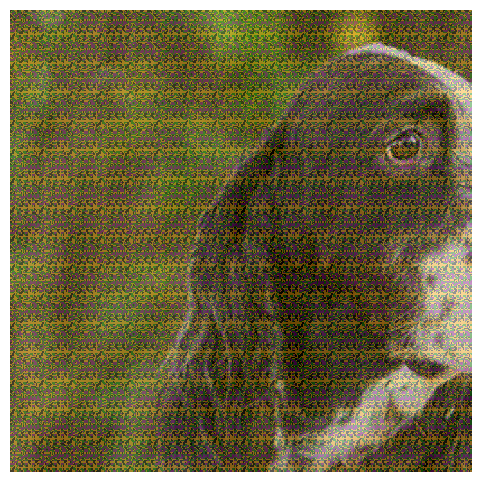

In [15]:
pred = unpatch(model(patch(bla_ds[0][0])))
plot_imgs(imgs=[bla_ds[0][0]], masks=list(pred.argmax(1)), figsize=(6, 6))

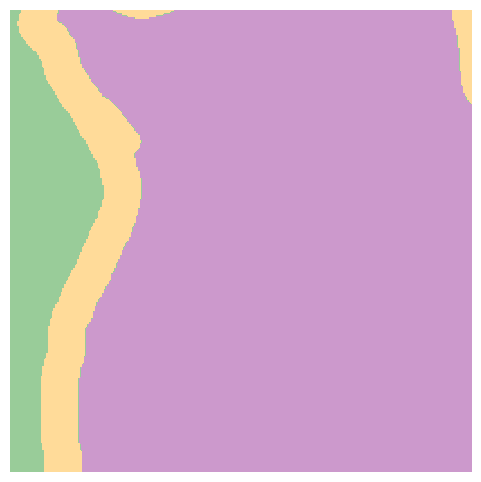

In [16]:
plot_imgs(masks=[masks[0]], figsize=(6, 6))

## 3. Data augmentations

- Useful since it effectively increases the size of our training dataset
- Necessary to crop the images to a sensible size since the largest would become a sequence of $22.500$ patches
    - Way to large to fit on a consumer grade graphics card
    - Therefore 